## Import Libraries
Libraries needed for importing, processing and visualising the datasets are imported here

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pathlib

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

tensorflow version: 2.6.0
pandas version: 1.3.4
numpy version: 1.19.5
seaborn version: 0.11.2
GPU present


2022-04-13 10:28:42.426417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 10:28:42.461016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 10:28:42.461147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Import Datasets
Datasets in the designated folders are imported as `pandas.DataFrame` objects.<br>
Dataset signal types and collection locations are automatically determined by their file names:
1. full path is read using `pathlib` libaray
2. using the naming format `<signal>_<location>_<increment>.csv`, the signal type and collection locations are extracted programmatically
3. all signals present are then encoded into a tag, with the signals sorted by alphanumeric order, in the format `{<signal> : <tag>}`, where `<tag>` is `0` to `n` number of signal types

In [2]:
# paths to load datasets from
train_store_path = '../datasets/sa/training'
val_store_path = '../datasets/sa/validation'

# convert to pathlib Path objects
train_dir = pathlib.Path(train_store_path)
val_dir = pathlib.Path(val_store_path)

# get list of datasets in dir
train_ds_paths = sorted(list(train_dir.glob('*.csv')))
val_ds_paths = sorted(list(val_dir.glob('*.csv')))

# extract classification target from file names
train_ds_type = np.array([x.parts[-1].split('_')[:2] for x in train_ds_paths])
val_ds_type = np.array([x.parts[-1].split('_')[:2] for x in val_ds_paths])

train_ds_order = [s.upper() for s in train_ds_type[:,0]]
val_ds_order = [s.upper() for s in val_ds_type[:,0]]

train_ds_loc = [s.upper() for s in train_ds_type[:, 1]]
val_ds_loc = [s.upper() for s in val_ds_type[:, 1]]

# generate signal type tags
signal_tags = {k : i for i, k in enumerate(np.unique(sorted([s.upper() for s in train_ds_order] + ['NOISE'])))}

print(signal_tags)

{'BNET': 0, 'BT': 1, 'FM': 2, 'FNET': 3, 'LTE': 4, 'NOISE': 5, 'WIFI': 6}


Dataset importing process:
1. datasets are loaded using the `pandas.read_csv()` function into 2 different `DataFrame` objects, one containing dataset information and the other containing the data
    1. all necessary dataset information like `NumberSamples`, `NumberRecords`, and `SamplingFrequency` are present in the first 10 rows, as such the information object only reads the first 10 rows to save time
    2. the first 10 rows are subsequently skipped when importing the data
2. unnecessary information are dropped from both dataframes
    1. the dataset is separated into invididual records with these in between in the csv: `['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame']`. These are dropped to clean up the dataset.
    2. the information dataframe contains `['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame']`, which are unnecessary and are thus dropped.
3. All the processed dataframes are appended into corresponding `specs` and `datasets` lists, split by training and validation datasets

In [4]:
# load the dataset(s)

# load dataset information
specs = []
datasets = []

for dataset_paths in [train_ds_paths, val_ds_paths]:
    temp_ds = []
    temp_specs = []
    
    for path in dataset_paths:
        print(f'loading {path}...', end=' ')

        # load dataset details
        df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
        df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')

        temp_specs.append(df_spec)

        # load data, strip unnecessary bits out
        df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])
        df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
        df['I'] = df['I'].astype('float')

        print(f'loaded')

        temp_ds.append(df)
        
    datasets.append(temp_ds)
    specs.append(temp_specs)
    
print('done.')

loading ../datasets/sa/training/bnet_office_1.csv... loaded
loading ../datasets/sa/training/bnet_roof_1.csv... loaded
loading ../datasets/sa/training/bt_library_1.csv... loaded
loading ../datasets/sa/training/bt_office_1.csv... loaded
loading ../datasets/sa/training/bt_room_1.csv... loaded
loading ../datasets/sa/training/fm_roof_1.csv... loaded
loading ../datasets/sa/training/fnet_library_1.csv... loaded
loading ../datasets/sa/training/fnet_office_1.csv... loaded
loading ../datasets/sa/training/fnet_roof_1.csv... loaded
loading ../datasets/sa/training/fnet_room_1.csv... loaded
loading ../datasets/sa/training/lte_library_1.csv... loaded
loading ../datasets/sa/training/lte_library_2.csv... loaded
loading ../datasets/sa/training/lte_library_3.csv... loaded
loading ../datasets/sa/training/lte_office_1.csv... loaded
loading ../datasets/sa/training/lte_office_2.csv... loaded
loading ../datasets/sa/training/lte_room_1.csv... loaded
loading ../datasets/sa/training/lte_room_2.csv... loaded
load

## Data pre-processing
Pre-processing process:
1. desired record length is defined by `rlength`
2. iterate through list of dataframes, starting with training datasets
3. extract each record based on `NumberSamples` defined by dataset's corresponding information dataframe regardless of `rlength`
4. check if `NumberSamples` is longer or shorter than `rlength`
    1. if longer, truncate record to `rlength`
    2. if shorter, pad record to `rlength` with a random amount of padding on the left and right of the record
    3. else, do nothing and use record as-is
5. add record to `temp_processed` which is then added to `processed`, to ensure training and validation data are split up correctly
    1. all records follow the format `[<signal>, <tag>, <location>, <data>]`
6. records are merged into a training dataframes: `df_train` and `df_test` for training and validation data respectively
7. shuffle training and validation datasets to ensure training and minimise overfit

In [5]:
# split dataset(s) into records, extract test dataset
processed = []

# number of test records to extract
ntest = 100
rlength = 1024

for h in range(len(datasets)):
    temp_processed = []
    
    print(f'\nType\t\tLocation\tTotal Records\tSamples/Record')
    for i in range(len(datasets[h])):
        nrecords = specs[h][i].loc['NumberRecords']['info'] if not h else 400
        nsamples = specs[h][i].loc['NumberSamples']['info']
        ds_length = datasets[h][i].shape[0]
        
        # make life easier
        ds_order = train_ds_order if not h else val_ds_order
        ds_loc = train_ds_loc if not h else val_ds_loc

        # sanity check
        print(f'{ds_order[i]:<13}\t{ds_loc[i]:<15}\t{nrecords:<7}\t\t{nsamples:<7}')

        # loop through dataset to split 
        for j in range(nrecords):
            # extract sample length worth of samples for each record, then transpose for easier access later
            record = datasets[h][i].iloc[(nsamples * j):(nsamples * (j+1))].values.T

            # pad shorter records with random padding to rlength
            if nsamples < rlength:
                # deterine pad amount
                pad_length = rlength - nsamples
                lpad_length = np.random.randint(0, pad_length+1)
                rpad_length = pad_length - lpad_length

                # generate pad
                lpad = np.zeros((2, lpad_length))
                rpad = np.zeros((2, rpad_length))

                # concatenate pad
                record = np.concatenate([lpad, record, rpad], axis=1)

            # truncate longer records to rlength
            elif nsamples > rlength:
                record = record[:,:rlength]

            # add processed record to list
            temp_processed.append([ds_order[i], signal_tags[ds_order[i]], ds_loc[i], record])
            
    processed.append(temp_processed)

# convert list into dataframes for later use, randomise, extract test records
df_train = pd.DataFrame(processed[0], columns=['signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)
df_test = pd.DataFrame(processed[1], columns=['signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)

# print dataset statistics
print(f'\n{"Stats":^30}')
print(f'Dataset\tLength\tRecords/Sample')
print(f'Train\t{df_train.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')
print(f'Test\t{df_test.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')


Type		Location	Total Records	Samples/Record
BNET         	OFFICE         	12684  		1024   
BNET         	ROOF           	5743   		1024   
BT           	LIBRARY        	5869   		1024   
BT           	OFFICE         	23885  		1014   
BT           	ROOM           	9000   		1024   
FM           	ROOF           	5300   		1280   
FNET         	LIBRARY        	6343   		1024   
FNET         	OFFICE         	4500   		1024   
FNET         	ROOF           	3151   		1024   
FNET         	ROOM           	2450   		1024   
LTE          	LIBRARY        	1200   		1024   
LTE          	LIBRARY        	1450   		1024   
LTE          	LIBRARY        	1500   		1024   
LTE          	OFFICE         	3202   		1014   
LTE          	OFFICE         	3550   		1014   
LTE          	ROOM           	1850   		1024   
LTE          	ROOM           	1650   		1024   
LTE          	ROOM           	1300   		1024   
WIFI         	LIBRARY        	1250   		1024   
WIFI         	LIBRARY        	1200   		1024   
WIFI         	L

In [6]:
# set all noise as another class
min_amp = 0.005

for dataset in [df_train, df_test]:
    for key, value in signal_tags.items():
        if key == 'NOISE' or key == 'FM':
            continue

        if key == 'BNET':
            min_amp = 0.0025
        else:
            min_amp = 0.005
        

        # get subset of main datasets
        temp_subset = dataset[dataset['signal_type'] == key]
        noisy_data = temp_subset[[i.max() <= min_amp for i in temp_subset['record'].values]]
        
        # if key == 'BNET' or key == 'BT':
        #     noisy_data = noisy_data.sample(frac=0.45)

        dataset.loc[noisy_data.index, ['signal_type', 'tag']] = 'NOISE', signal_tags['NOISE']

        print(key, np.array(np.sum([i.max() <= min_amp for i in temp_subset['record'].values])))

BNET 7793
BT 24366
FNET 2131
LTE 3126
WIFI 4808
BNET 332
BT 797
FNET 121
LTE 7
WIFI 458


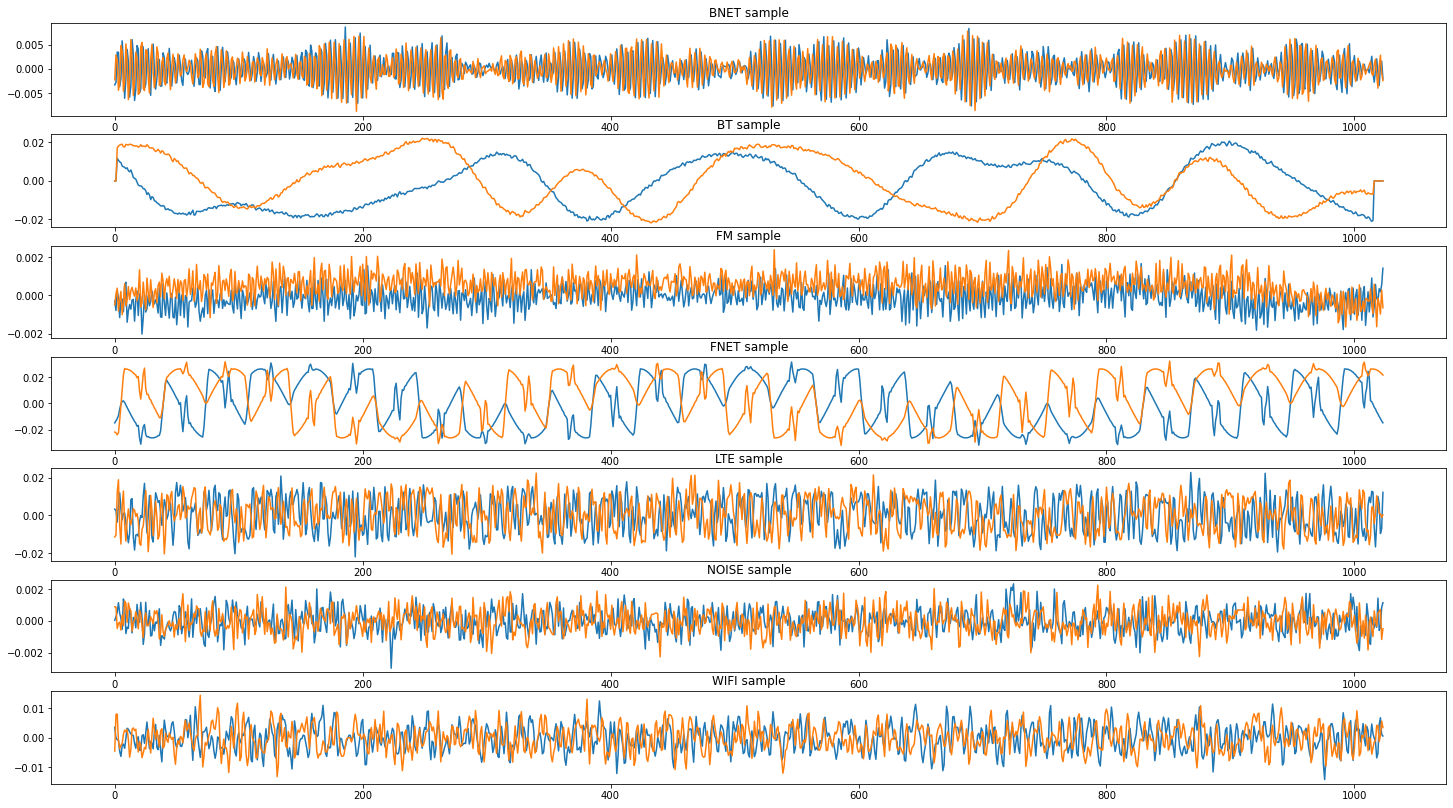

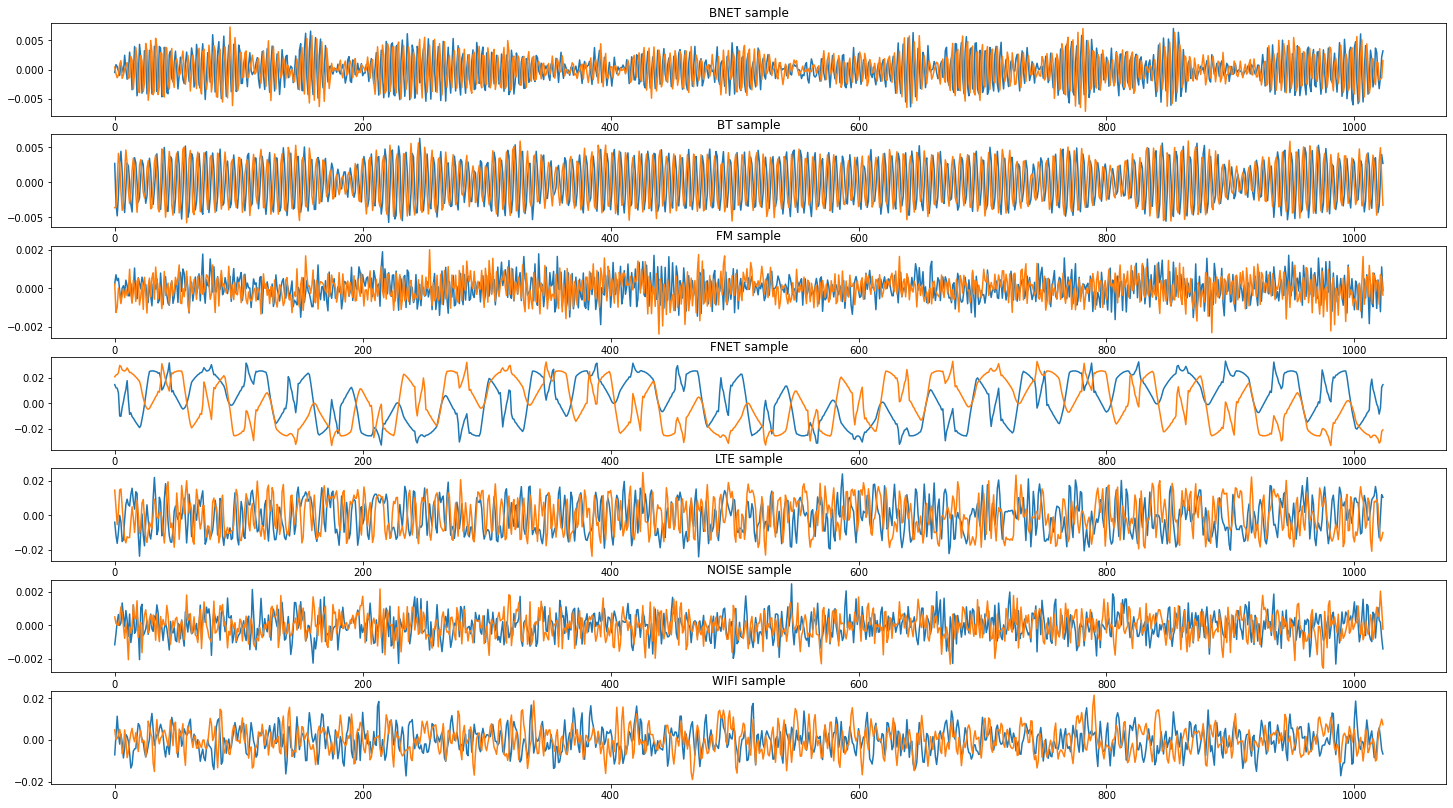

In [7]:
# plot some sample signals
fig1 = plt.figure(1, figsize=(25, 14))
fig2 = plt.figure(2, figsize=(25, 14))

for i, key in enumerate(list(signal_tags.keys())):
    # training data
    ip, qd = df_train[df_train['signal_type'] == key]['record'].sample().iloc[0]
    while (ip.max() < min_amp or qd.max() < min_amp) and key not in ['FM', 'NOISE']:
        ip, qd = df_train[df_train['signal_type'] == key]['record'].sample().iloc[0]
    
    ax = fig1.add_subplot(len(signal_tags), 1, i+1)

    ax.plot(ip)
    ax.plot(qd)
    
    ax.set_title(f'{key} sample')
    
    # validation data
    ipv, qdv = df_test[df_test['signal_type'] == key]['record'].sample().iloc[0]
    while (ipv.max() < min_amp or qdv.max() < min_amp) and key not in ['FM', 'NOISE']:
        ipv, qdv = df_test[df_test['signal_type'] == key]['record'].sample().iloc[0]    
    ax = fig2.add_subplot(len(signal_tags), 1, i+1)

    ax.plot(ipv)
    ax.plot(qdv)
    
    ax.set_title(f'{key} sample')
    
plt.show()

## Model construction and training
This particular model cannot be fully constructed using the Keras API due to the use of skip-connections, instead the Tensorflow Functional API is used.

In [8]:
# import model stuff
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dense, Input, Flatten, Reshape

In [9]:
# functions for model segments
def encoder(x):
    '''
    Function to create encoder section of model. 

    PARAMETERS:
    x: previous layer of model to connect to
    '''

    x = Conv2D(256, (2, 2), activation='tanh', padding='same', trainable=False)(x)
    x = MaxPooling2D((1, 2), padding='same', trainable=False)(x)
    x = Conv2D(256, (2, 2), activation='tanh', padding='same', trainable=False)(x)
    x = MaxPooling2D((1, 2), padding='same', trainable=False)(x)


    return x

def decoder(x):
    '''
    Function to create decoder section of model. 

    PARAMETERS:
    x: previous layer of model to connect to
    '''
    x = Conv2DTranspose(512, (2, 2), strides=(1, 2), activation='selu', padding='same')(x)
    x = Conv2DTranspose(512, (2, 2), strides=(1, 2), activation='selu', padding='same')(x)

    return x

In [10]:
# function to create main model
def create_model(in_dim, name):
    '''
    function to construct the actual resnet model.

    INPUT PARAMETERS
    in_dim: dimensions of input
    name: name of the model for identification
    '''

    input_layer = Input(in_dim)
    
    # encoder
    x = encoder(input_layer)

    # training layer
    # x = Flatten()(input_layer)
    x = Dense(np.prod(in_dim)//8, activation='selu')(x)
    # x = Dense(np.prod(in_dim), activation='tanh')(x)
    # x = Reshape(in_dim)(x)

    # decoder
    x = decoder(x)

    output_layer = Conv2D(1, (2, 2), activation='tanh', padding='same')(x)

    # turn layers into model
    model = Model(inputs=input_layer, outputs=output_layer, name=name)

    return model

In [14]:
# custom loss function
# 1. find absolute difference between each value in array
# 2. find mean difference
# 3. return loss

def custom_loss(y_actual, y_pred):
    difference = tf.math.abs(tf.math.subtract(y_actual, y_pred))
    loss = tf.math.reduce_mean(difference)

    return loss

In [15]:
models = [create_model((2, rlength, 1), f'AANN_{name}') for name in signal_tags.keys()]

# tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
print([model.summary() for model in models])

Model: "AANN_BNET"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 1024, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 1024, 256)      1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 512, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 512, 256)       262400    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 256, 256)       0         
_________________________________________________________________
dense (Dense)                (None, 2, 256, 256)       65792     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 512, 512)       52

The model is trained here, with early stopping to minimise overfit.

In [17]:
# train model
# import metrics
# from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# store history of model training in dict
histories = signal_tags.copy()

for model, name in zip(models, signal_tags.keys()):
    # subset data for training
    X_train = np.concatenate(df_train[df_train['signal_type'] == name]['record'].values).reshape(
        (df_train[df_train['signal_type'] == name].shape[0], 2, rlength, 1))

    #early stopping
    callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

    # compile model for training
    model.compile(optimizer=Adam(), loss=custom_loss)

    # train model and store training history
    histories[name] = model.fit(X_train, X_train, epochs=500, batch_size=64, callbacks=[callback], validation_split=0.2)

2022-04-13 10:39:28.464626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-04-13 10:39:29.456997: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-04-13 10:39:30.396731: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-13 10:39:30.397192: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-13 10:39:30.397222: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-04-13 10:39:30.397733: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-13 10:39:30.397788: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-13 10:39:31.330271: I tensorflow/stream_executor/cuda/c

133/133 [==============================] - 21s 117ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 2/500
133/133 [==============================] - 13s 99ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/500
133/133 [==============================] - 13s 99ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/500
133/133 [==============================] - 13s 100ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/500
133/133 [==============================] - 15s 109ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/500
133/133 [==============================] - 13s 100ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/500
133/133 [==============================] - 13s 100ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/500
133/133 [==============================] - 13s 100ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/500
133/133 [==============================] - 13s 100ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/500
133/133 [==============================] - 13s 100ms/step - loss:

2022-04-13 11:48:24.139474: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 276717568 exceeds 10% of free system memory.
2022-04-13 11:48:24.395049: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 276717568 exceeds 10% of free system memory.
2022-04-13 11:48:24.529897: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 276717568 exceeds 10% of free system memory.
2022-04-13 11:48:24.615783: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 276717568 exceeds 10% of free system memory.


Epoch 1/500
528/528 [==============================] - 56s 105ms/step - loss: 0.0010 - val_loss: 5.1726e-04
Epoch 2/500
528/528 [==============================] - 53s 100ms/step - loss: 8.3063e-04 - val_loss: 4.5249e-04
Epoch 3/500
528/528 [==============================] - 53s 101ms/step - loss: 3.7772e-04 - val_loss: 3.4106e-04
Epoch 4/500
528/528 [==============================] - 53s 100ms/step - loss: 3.1964e-04 - val_loss: 3.0314e-04
Epoch 5/500
528/528 [==============================] - 53s 101ms/step - loss: 3.1111e-04 - val_loss: 3.1082e-04
Epoch 6/500
528/528 [==============================] - 53s 101ms/step - loss: 3.1042e-04 - val_loss: 2.7689e-04
Epoch 7/500
528/528 [==============================] - 53s 101ms/step - loss: 2.9751e-04 - val_loss: 2.3392e-04
Epoch 8/500
528/528 [==============================] - 54s 102ms/step - loss: 2.5838e-04 - val_loss: 2.6651e-04
Epoch 9/500
528/528 [==============================] - 53s 100ms/step - loss: 3.0087e-04 - val_loss: 2.4382e

## Model Evaluation

In [18]:
# evaluate model performance on standard dataset
for model, name in zip(models, signal_tags.keys()):
    # subset data for testing
    X_test = np.concatenate(df_test[df_test['signal_type'] == name]['record'].values).reshape(
        (df_test[df_test['signal_type'] == name].shape[0], 2, rlength, 1))

    model.evaluate(X_test)

24/24 [==============================] - 0s 575us/step - loss: 0.0000e+00


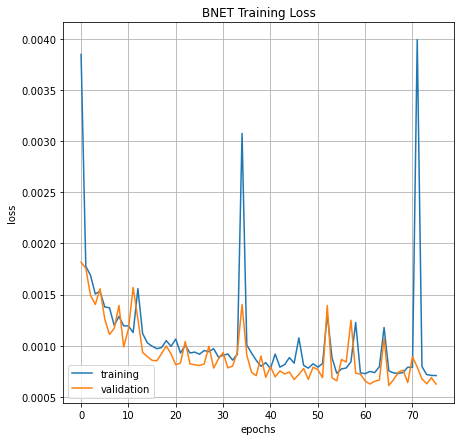

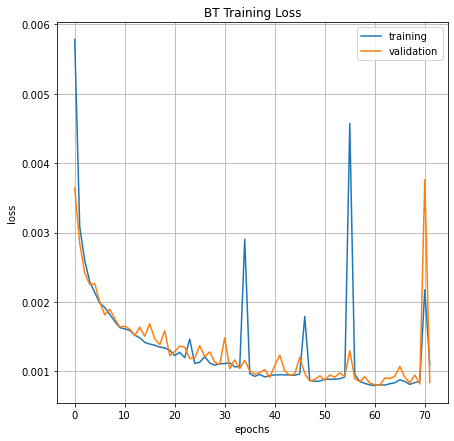

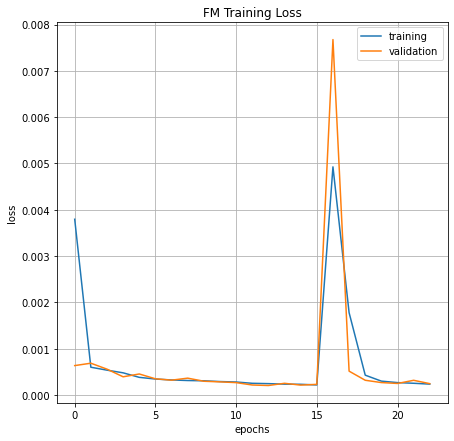

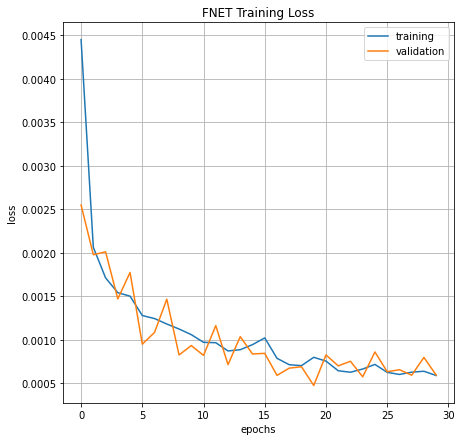

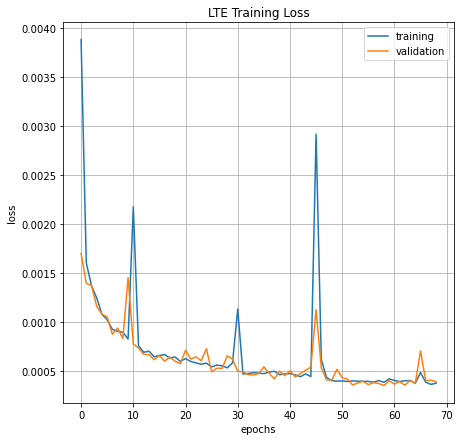

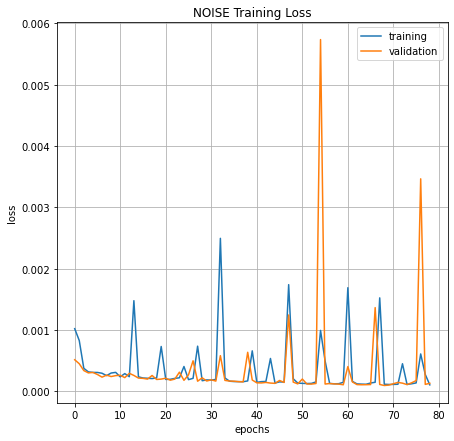

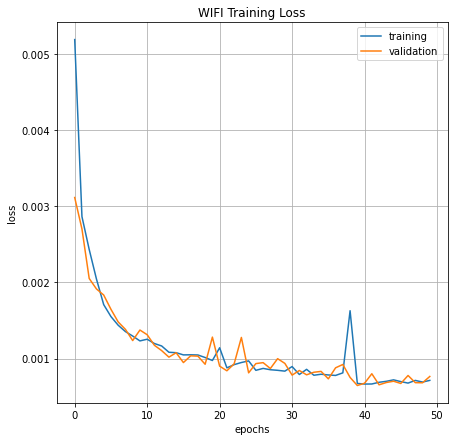

In [19]:
# plot out loss and accuracy graphs
for i, name in enumerate(signal_tags.keys()):
    train_hist = histories[name].history

    fig = plt.figure(i, figsize=(7, 7))

    # loss graph
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(train_hist['loss'], label='training')
    ax1.plot(train_hist['val_loss'], label='validation')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.set_title(f'{name} Training Loss')
    ax1.legend()
    ax1.grid(b=True)

    # # accuracy graph
    # ax2 = fig.add_subplot(1, 2, 2)
    # ax2.plot(train_hist['accuracy'], label='training')
    # ax2.plot(train_hist['val_accuracy'], label='validation')
    # ax2.set_xlabel('epochs')
    # df_test[df_test['signal_type'] == key]['record'].sample()
    # ax2.set_ylabel('accuracy')
    # ax2.set_title('Training Accuracy')
    # ax2.legend()
    # ax2.grid(b=True)

    plt.show()

(2, 1024)
(2, 1024)
0.0007225010820468891
0.00044035446252710625


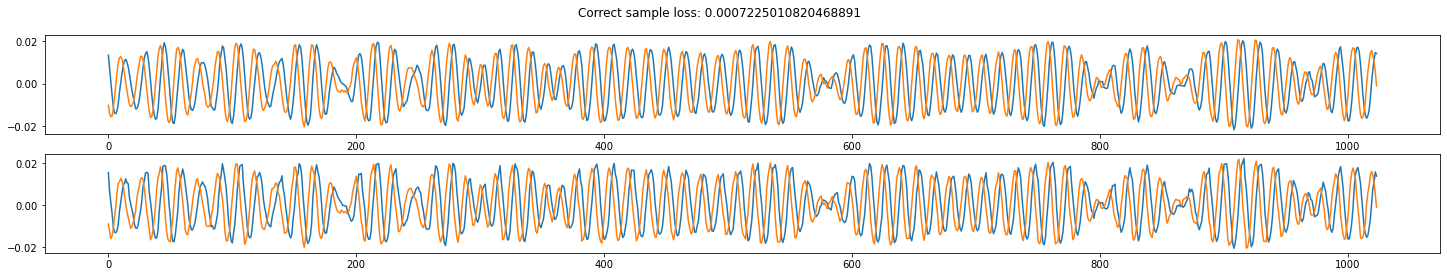

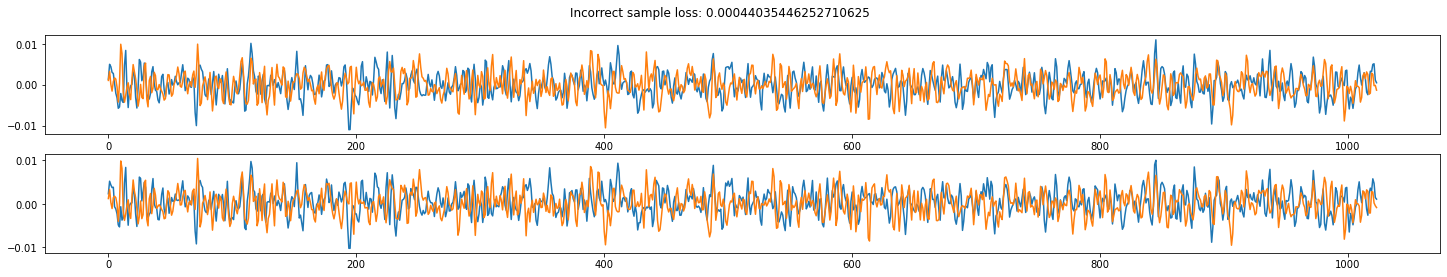

In [49]:

# test model
# pull random sample from BT and WIFI 
correct_sample = df_test[df_test['signal_type'] == 'BT'].sample(1)['record'].values[0]
incorrect_sample = df_test[df_test['signal_type'] == 'WIFI'].sample(1)['record'].values[0]

print(correct_sample.shape)
print(incorrect_sample.shape)

# test model
correct_pred = models[signal_tags['WIFI']].predict(correct_sample.reshape(-1, 2, 1024, 1)).reshape(2, 1024)
incorrect_pred = models[signal_tags['WIFI']].predict(incorrect_sample.reshape(-1, 2, 1024, 1)).reshape(2, 1024)

# calc loss
loss = custom_loss

print(loss(correct_sample, correct_pred).numpy())
print(loss(incorrect_sample, incorrect_pred).numpy())

# plot correct sample
fig2 = plt.figure(2, figsize=(25, 4))
fig2.suptitle(f'Correct sample loss: {loss(correct_sample, correct_pred).numpy()}')

ax21 = fig2.add_subplot(211)
ax21.plot(correct_sample[0])
ax21.plot(correct_sample[1])

ax22 = fig2.add_subplot(212)
ax22.plot(correct_pred[0])
ax22.plot(correct_pred[1])

# plot incorrect sample
fig3 = plt.figure(3, figsize=(25, 4))
fig3.suptitle(f'Incorrect sample loss: {loss(incorrect_sample, incorrect_pred).numpy()}')

ax31 = fig3.add_subplot(211)
ax31.plot(incorrect_sample[0])
ax31.plot(incorrect_sample[1])

ax32 = fig3.add_subplot(212)
ax32.plot(incorrect_pred[0])
ax32.plot(incorrect_pred[1])

plt.show()

In [50]:
# save model
for model, name in zip(models, signal_tags.keys()):
    model.save(f'../saved_models/AANN/{name}')

2022-04-13 13:16:16.119738: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../saved_models/AANN/BNET/assets
INFO:tensorflow:Assets written to: ../saved_models/AANN/BT/assets
INFO:tensorflow:Assets written to: ../saved_models/AANN/FM/assets
INFO:tensorflow:Assets written to: ../saved_models/AANN/FNET/assets
INFO:tensorflow:Assets written to: ../saved_models/AANN/LTE/assets
INFO:tensorflow:Assets written to: ../saved_models/AANN/NOISE/assets
INFO:tensorflow:Assets written to: ../saved_models/AANN/WIFI/assets
